# Наработки на 17 марта

Всю работу можно разделить на 3 главных пункта:
* Бинаризация данных
* Выбор интересных гипотез для максимизации AUC-ROC 
* Тестирование метрики стабильности

Все примеры приводятся на анализе данных из Bank Marketink датасета из UCI: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

## Бинаризация данных

__Задача__

Создать формальный контекст с минимальный набором аттрибутов, на основе которого можно было бы с высокой точностью предсказать поведение Чёрного ящика. Желательно, чтобы алгоритм работал быстро.

__Идея решения__

Можно воспользоваться стандартным подходом отбора признаков: генерации большого количества изначальных бинарных факторов и поочерёдном удалении факторов, не влияющих на качество предсказания.

В качестве алгоритма для проверки качества ("полноты", "достаточности") контеста можно использовать деревья решений или случайный лес. Т.к.
1. они очень быстро обучаются
2. принцип работы дерева решений похож на гипотезы из FCA: каждый путь от вершины дерева до листа это пересечение нескольних бинарных признаков

__Алгоритм__

1. Генерация бинарных признаков
    1. Разложить категориальные признаки из исходного датасета в OneHot Encoding (в т.ч. получить признаки - отрицание разложения OHE)
    2. Для каждого числового признака $m$ взять $n$ случайных значений $t_i$ этого признака, ориентируясь на его плотность распределения. На основе полученных значений составить бинарные признаки: "$m < t_i $", "$m \geq t_i$"
    3. Проверить качество предсказания работы Чёрного ящика через RandomForest модель на полученном бинарном датасете. Если оно меньше требуемого (напр. accuracy=1), то повторить п.1.A, увеличив $n$ или надеятся на случайную природу выбора порогов $t_i$
2. Отбор лучших признаков
    1. Отсортировать признаки основываясь на значениях Feature Importance, получаемых от модели Random Forest.
    2. Перебирать все признаки начиная с самых "неважных": если удаление некого признака даёт ухудшение качества не больше чем на $\delta$, то удалить признак и перейти к п.2.A


__Пример__

Провели OneHot Encoding для категориальных признаков. Каждый целочисленный признак разбили по 5 пороговым значениям. Получили 142 базовых бинарных признака при 4521 объектах. Качетсво предсказания результата Чёрного ящика: accuracy=1.

Весь алгоритм занимает обычно пару минут времени, что очень неплохо.
![bin_selection_speed.png](../results/17_mar_images/bin_selection_speed.png)

Минимальное кол-во признаков, которые дают accuracy=1 - 26. Но на этих признаках долго считаются понятия, поэтому выберем признаки, которые дают качество >0.95.
Итого осталось 8 бинарных признаков на которых RandomForest даёт качество accuracy=0.95001, auc-roc=0.934. Т.е. можно надеятся, что в данных содержится бОльшая часть информации, необходимая для объяснения работы Чёрного ящика. Также, если из контекста убрать объекты с одинаковыми признаками, получим 96 уникальных объектов (2% от исходного кол-ва объектов).



__Интересный факт__

Сперва удивляет то, что мы можем получить бинарный датасет, на котором можно получить качество accuracy=1. С другой стороны, мы предсказываем не какой-то объект реального мира, со всей своей сложностью и случайностью, мы предсказываем предсказание Чёрного ящика - детерминированного (в большинстве случаев) алгоритма, ориентирующегося только на данные из обучающего датасета. В случае если у нас нет обучающего датасета, получить подобные бинарные представления всё ещё можно, хоть и чуть сложнее.

## Максимизация AUC-ROC

__Задача__

1. Нужно как-то оценивать качество полученной решётки понятий.
2. Нужно сократить кол-во понятий в решётке, чтобы сделать её более простой для восприятия

__Идея решения__

Сначала определим алгоритм, с помощью которого будем предсказывать целевую переменную для каждого объекта из формального контекста.
Для каждого объекта $g \in G$ ищем максимальное понятие, в котором он находится, и возвращаем среднее целевое значение среди объектов этого понятия.

Можно представить ситуацию, когда есть три понятия $C_1=(A_1,B_1)$, $C_2=(A_2,B_2)$, $C_3=(A_3,B_3)$ и целевая переменная $Y$, такие что $C_3<C_1$, $C_3<C_2$, $\mathbb{E}[Y|C_1]=0.1<\mathbb{E}[Y|C_3]=0.5<\mathbb{E}[Y|C_2]=0.9$. Тогда при удалении понятия $C_3$ объекты, для которых это понятие максимальное, "перейдут" в понятия $C_1$, $C_2$ и качество их предсказаний может улучшиться из-за более "определённых" вероятностей понятий $C_1, C_3$.

__Алгоритм__

Пока, на первой итерации, я не придумал меру интересности понятия, способную быстро выбрать понятия, максимизирующие AUC-ROC. Поэтому воспользуемся алгоритмом, похожим на отбор лучших бинарных признаков:
1. Выберем все понятия, по которым мы предсказываем вероятности объектов
2. Попробуем по очереди удалять каждое из понятий, записывая изменение метрики ROC-AUC
3. Убираем понятие, исключение которого дало наибольший прирост в качестве. Если такого нет, завершаем алгоритм.

__Пример__

![best AUC ROC concepts](../results/17_mar_images/best_roc_concepts_speed.png)

Изначально было 144 гипотезы и AUC ROC=0.8881. После отбора лучших гипотез осталось 72 гипотезы (50%) и AUC ROC=0.9205.

График возрастания качества будет ниже

## Тестирование метрики стабильности

__Задача__

1. Необходимо быть уверенным, что понятия, которые мы нашли - не появились из-за шума в данных. Что на новых данных они дадут похожий результат.
2. Нужно сократить кол-во понятий в решётке, чтобы сделать её более простой для восприятия

__Идея решения и алгоритм__

Используем метрику Стабильность. А точнее её приближения: верхнюю и нижнюю $\Delta$ границы, логарифмическую стабильность. Уберём понятия, для которых значение лографмической стабильности было меньше 5 (т.е. вер-ть появления такого понятия <97%). Затем попробуем выбрать лучшие из стабильных понятий через алгоритм максимизации AUC ROC.

__Пример__

Изначально было 144 гипотезы и AUC ROC=0.8881. После отсечения нестабильных гипотез (LStab<5) осталось 107 понятий и AUC ROC=0.8943.

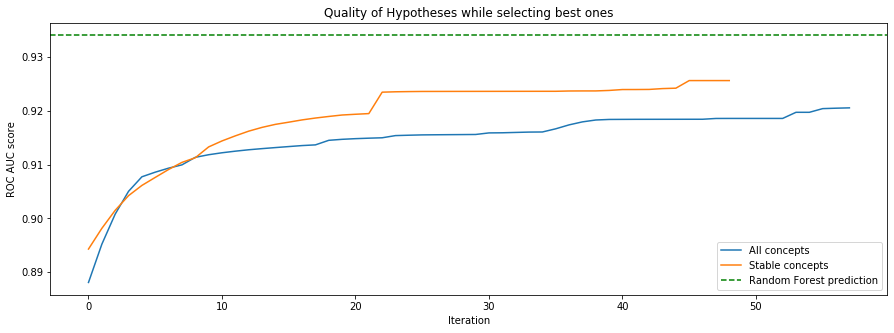
_На изображении: возрастание качества решётки понятий от количества удалённых понятий_


Стоит заметить, что во всех предыдущих экспериментах качество стабильной решётки __после__ удаления части понятий было хуже, чем качество аналогичной нестабильной решётки. Но, качество стабильной решётки __до__ удаления понятий всегда было лучше нестабильной. Разумеется, для полной уверенности нужно провести больше экспериментов.

# Планы на будущее

* Реализовать построение понятий на узорных структурах
* Прочитать статью Efficient Mining of Subsample-Stable Graph Patterns, найти новые идеи по использованию стабильности
* Придумать более математический способ выбора гипотез для максимизации AUC ROC.
* Найти метрику, которая всегда будет лучше работать на стабильных гипотезах, чем на нестабильных - наверное надо просто оценивать качество построенных понятий на тестовой выборке